# Image Segmentation using Traditional Machine Learning

### Here is the main plan: 
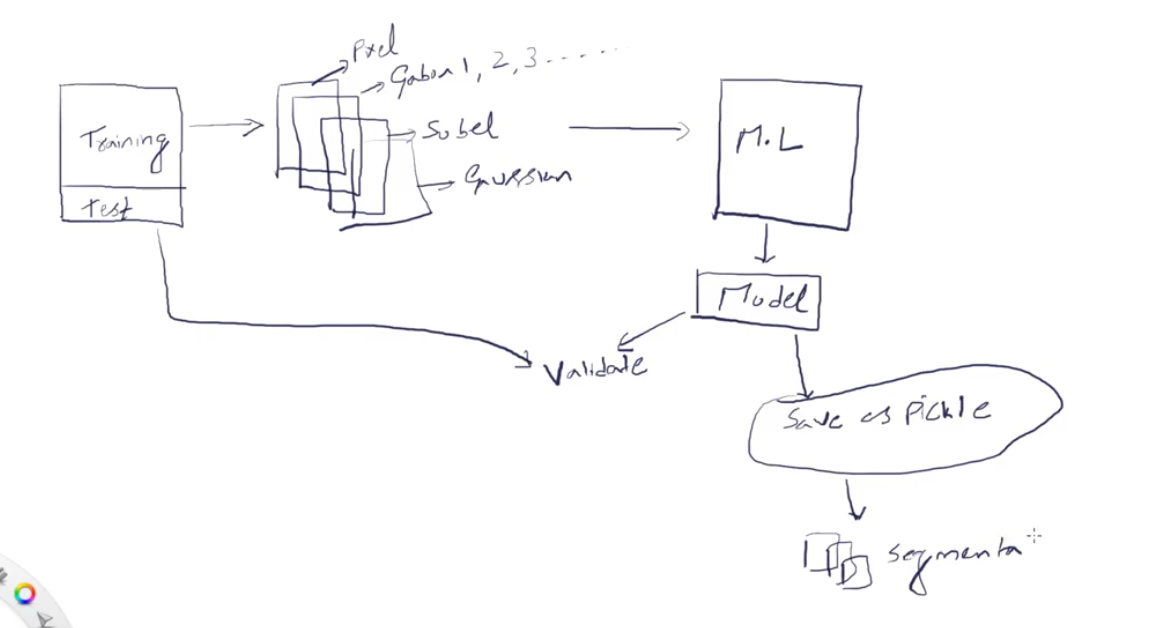

1) We are going to extract a ton of features from an initial image using Gabor filters, Sobel filters, the orginal pixel values themselves, etc.

2) Next, we are going to split our image pixel by pixel, where each pixel will be defined by a vector of the above feature values.

3) We are going to split pixels into training and testing sets. Then we are going to train/validate on our test set. 

4) We are going to save our trained model as a Pickle file. 

5) In the meantime, we are also going to find which features are relevant. 

In [171]:
import numpy as np
import cv2 
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
import glob
from tqdm import tqdm


#images themselves
train_dir = '/Users/matthewmiller/Desktop/sreeni_github/images/train_images'
test_dir = '/Users/matthewmiller/Desktop/sreeni_github/images/test_images'

#masks 
train_masks = '/Users/matthewmiller/Desktop/sreeni_github/images/Train_masks'

#the 4th vid in the train images directory happens to be the one in the video
sreenis_image = os.path.join(train_dir,os.listdir(train_dir)[4])

#read in image, then convert to grayscale
img = cv2.cvtColor(cv2.imread(sreenis_image),cv2.COLOR_BGR2GRAY)

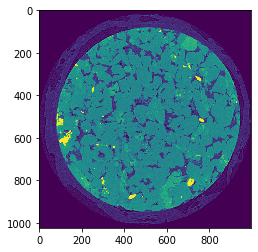

In [107]:
#let's look at this image now...
plt.imshow(img)

### Ok! Let's now put together our features!

In [108]:
#lets now start defining a dataframe to keep all of our features
df = pd.DataFrame()

#lets add our original pixel values first
img2 = img.reshape(-1) #unwarp image
df['Original Image']=img2

#now let's add Gabor features!

num = 1
print('------------INITIALIZING PRINTING GABOR PARAMETERS------------')
for theta in range(2):
    theta=theta/4*np.pi  
    for sigma in (3,5):
        for lamda in np.arange(0,np.pi,np.pi/4):
            for gamma in (0.05,0.5):
                gabor_label = 'Gabor'+str(num)
                kernel = cv2.getGaborKernel((5,5),sigma,theta,lamda,gamma,0,ktype=cv2.CV_32F)
                fimg = cv2.filter2D(img,cv2.CV_8UC3,kernel)
                filtered_img = fimg.reshape(-1)
                print(gabor_label,':theta =',theta,':sigma =',sigma,':lamda =',lamda,':gamma =',gamma)
                df[gabor_label]=filtered_img
                num+=1
print('------------FINISHED PRINTING GABOR PARAMETERS------------')


#Now let's add a Canny edge filter!
edges = cv2.Canny(img,100,200)
edges1=edges.reshape(-1)
df['Canny Edge'] = edges1

#Now let's add some skimage filters
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#now some Gaussian filters

#GAUSSIAN with sigma=3
gaussian_img = nd.gaussian_filter(img,sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3']=gaussian_img1

#GAUSSIAN with sigma=3
gaussian_img2 = nd.gaussian_filter(img,sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7']=gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img,size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img,np.var,size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3']=variance_img1

------------INITIALIZING PRINTING GABOR PARAMETERS------------
Gabor1 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.05
Gabor2 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.5
Gabor3 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor4 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor5 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor6 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.5
Gabor7 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.05
Gabor8 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.5
Gabor9 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.05
Gabor10 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.5
Gabor11 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor12 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor13 :theta = 0.0 :sigma = 5 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor14 :theta = 0.0 :sigma = 5 :lamda = 1.570796326

In [110]:
#let's check out our dataframe!
print(df.head())
len(df.columns)

   Original Image  Gabor1  Gabor2  Gabor3  Gabor4  Gabor5  Gabor6  Gabor7  \
0               0       0       0       0       0       0       0       0   
1               0       0       0       0       0       0       0       0   
2               0       0       0       0       0       0       0       0   
3               0       0       0       0       0       0       0       0   
4               0       0       0       0       0       0       0       0   

   Gabor8  Gabor9  ...  Gabor31  Gabor32  Canny Edge  Roberts  Sobel  Prewitt  \
0       0       0  ...        0        0           0      0.0    0.0      0.0   
1       0       0  ...        0        0           0      0.0    0.0      0.0   
2       0       0  ...        0        0           0      0.0    0.0      0.0   
3       0       0  ...        0        0           0      0.0    0.0      0.0   
4       0       0  ...        0        0           0      0.0    0.0      0.0   

   Gaussian s3  Gaussian s7  Median s3  Variance s

41

### Ok, now let's map our images to our pixel labels!

In [111]:

#the 4th vid in the directory happens to be the one in the video
sreenis_mask = os.path.join(train_masks,os.listdir(train_masks)[4])

#read in image, then convert to grayscale
labeled_img = cv2.cvtColor(cv2.imread(sreenis_mask),cv2.COLOR_BGR2GRAY)
labeled_img1 = labeled_img.reshape(-1)

df['Labels']=labeled_img1

### Ok, now let's train a model using RF. 

Let's start by splitting into training/testing.Pay close attention to the `sklearn.model_selection.train_test_split` function, which unpacks 4 objects: `X_train`,`X_test`,`Y_train`, and `Y_test`   

In [112]:
#define dependent and independent variables

#1) Dependent variable (label):
Y = df['Labels'].values

#2) Independent variables:
X = df.drop(labels=['Labels'],axis=1) #this is an easy way to just drop entire columsn quickly
#note for the above that you need to list axis=1 to specify columns

#unpack it
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=20)

#create a model instance
model = RandomForestClassifier(n_estimators=10,random_state=42)

#fit this boi.
model.fit(X_train,Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Ok, we have fit the model! Now let's evaluate the results. 



In [113]:
#evaluate it on the training data itself! If it can't
#even get good performance on its own training data,
#then we probably shouldn't be too excited for its performance
#on other sets...
prediction_train = model.predict(X_train)

prediction_test = model.predict(X_test)

#### We interrupt this code cell to mention something important about model.predict()/model.predict_proba() in sklearn. 

If you want not only the prediction, but also the **probability** of that prediction, call `model.predict_proba()` for whatever sklearn model that you've imported. Try this out after to practice visualization, eh? Ok nice...

###### Ok now let's check out the accuracy of our model below:

In [114]:
print("Accuracy=",accuracy_score(Y_test,prediction_test))

Accuracy= 0.9861016467219986


# Next video: Which features are actually IMPORTANT?

Ok, now let's actually rank our features. For Random Forest, it's actually built in

In [115]:
#feature importance!
#get the actual list 
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)

In [116]:
feature_imp

Original Image    3.658682e-01
Gabor15           2.383418e-01
Gaussian s3       1.209190e-01
Gabor23           7.945061e-02
Gabor29           7.583085e-02
Median s3         3.976965e-02
Gaussian s7       1.445287e-02
Prewitt           1.078055e-02
Gabor7            1.054934e-02
Sobel             7.930006e-03
Roberts           6.025717e-03
Gabor8            6.004809e-03
Gabor16           5.429125e-03
Gabor31           4.905081e-03
Variance s3       2.375423e-03
Gabor32           2.229033e-03
Gabor24           2.008950e-03
Gabor22           1.928559e-03
Gabor30           1.740690e-03
Gabor21           1.713615e-03
Canny Edge        1.647330e-03
Gabor28           5.033614e-05
Gabor19           1.605031e-05
Gabor20           1.243784e-05
Gabor4            7.686642e-06
Gabor27           6.565950e-06
Gabor3            3.503810e-06
Gabor5            1.346538e-06
Gabor11           7.364150e-07
Gabor13           1.531759e-07
Gabor2            0.000000e+00
Gabor1            0.000000e+00
Gabor6  

### As you can see from the above, there are a lot of features not contributing anything to the ultimate accuracy of the model. Let's get rid of those in a future model so we can save computation time!

# Saving and Reusing Machine Learning Models with Pickle!

To save and reuse train models, we "pickle" the model. Let's check out how to pickle and save a model below with the `pickle.dump()` function!


In [117]:
#saving our pickled file:
filename = 'sandstone_model'
pickle.dump(model,open(filename,'wb'))

In [118]:
#reopening our pickled file:
load_model = pickle.load(open(filename,'rb'))
result = load_model.predict(X)

### Ok! Now that we have predicted on every pixel with our saved/loaded model, we can now visualize our result by reshaping the predicted pixel vector into the size of our original image. Here we go:

In [119]:
segmented = result.reshape((img.shape))

Text(0.5, 1.0, 'Segmented')

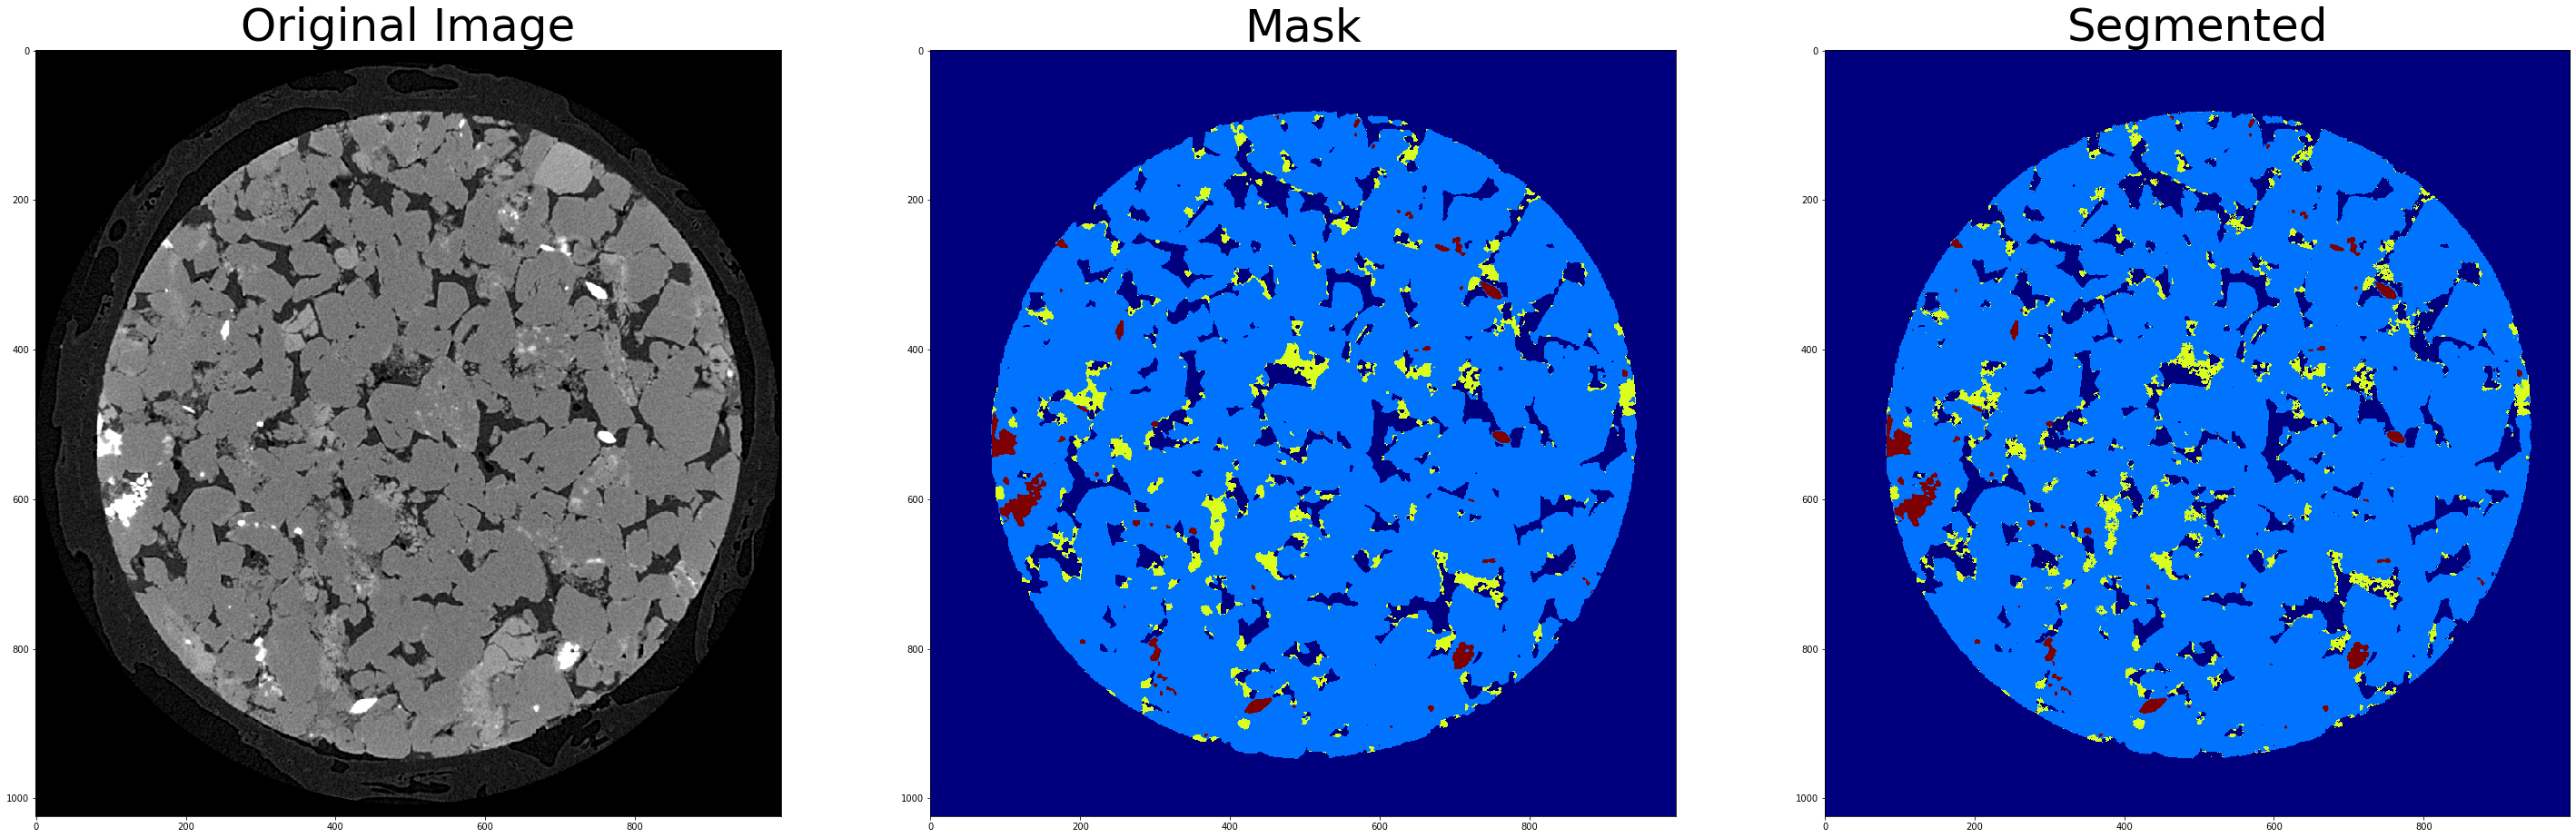

In [120]:
#Now let's visualize our original image versus the
#segmented version of it!

fig,ax = plt.subplots(1,3,figsize=(50,50))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original Image',size=50)
ax[1].imshow(labeled_img,cmap='jet')
ax[1].set_title("Mask",size=50)
ax[2].imshow(segmented,cmap='jet')
ax[2].set_title("Segmented",size=50)
# plt.imshow(segmented,cmap='jet')


# Next video: Applying a Saved Model to Multiple Images in a Directory

Exactly what it sounds like! We are also going to save the segmented images into a directory of our own!

First things first, though: in order to apply the same model to different images, we need to first **extract the same features** from the images we want to test over.

In [137]:
#let's make a feature extraction function that returns a df.
#Note: we don't have to worry about a "labels" column for 
#the dataframe that we're going to use this time. Why?
#Those labels were for training! Here we are just getting
#features out for testing 

def feature_extraction(input_img):
    #lets now start defining a dataframe to keep all of our features
    df = pd.DataFrame()
    
    if input_img.ndim==3 and input_img.shape[-1]==3:
        img = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
    elif input_img.ndim==2:
        img = input_img
    else:
        raise Exception("The module only works with grayscale and RBG images!")
    #lets add our original pixel values first
    img2 = img.reshape(-1) #unwarp image
    df['Original Image']=img2

    #now let's add Gabor features!

    num = 1

    for theta in range(2):
        theta=theta/4*np.pi  
        for sigma in (3,5):
            for lamda in np.arange(0,np.pi,np.pi/4):
                for gamma in (0.05,0.5):
                    gabor_label = 'Gabor'+str(num)
                    kernel = cv2.getGaborKernel((5,5),sigma,theta,lamda,gamma,0,ktype=cv2.CV_32F)
                    fimg = cv2.filter2D(img,cv2.CV_8UC3,kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label]=filtered_img
                    num+=1



    #Now let's add a Canny edge filter!
    edges = cv2.Canny(img,100,200)
    edges1=edges.reshape(-1)
    df['Canny Edge'] = edges1

    #Now let's add some skimage filters
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1

    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    #now some Gaussian filters

    #GAUSSIAN with sigma=3
    gaussian_img = nd.gaussian_filter(img,sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3']=gaussian_img1

    #GAUSSIAN with sigma=3
    gaussian_img2 = nd.gaussian_filter(img,sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7']=gaussian_img3

    #MEDIAN with sigma=3
    median_img = nd.median_filter(img,size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1

    #VARIANCE with size=3
    variance_img = nd.generic_filter(img,np.var,size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3']=variance_img1
    
    return df


In [95]:
os.listdir(train_dir)

['Sandstone_Versa0150.tif',
 'Sandstone_Versa0350.tif',
 'Sandstone_Versa0250.tif',
 'Sandstone_Versa0050.tif',
 'Sandstone_Versa0100.tif',
 'Sandstone_Versa0300.tif',
 'Sandstone_Versa0400.tif',
 'Sandstone_Versa0200.tif',
 'Sandstone_Versa0000.tif']

In [122]:
ex = cv2.imread((os.path.join(train_dir,os.listdir(train_dir)[1])))
ex = cv2.cvtColor(ex,cv2.COLOR_BGR2GRAY)
df =feature_extraction(ex)
print(len(df.columns))

------------INITIALIZING PRINTING GABOR PARAMETERS------------
Gabor1 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.05
Gabor2 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.5
Gabor3 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor4 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor5 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor6 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.5
Gabor7 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.05
Gabor8 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.5
Gabor9 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.05
Gabor10 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.5
Gabor11 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor12 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor13 :theta = 0.0 :sigma = 5 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor14 :theta = 0.0 :sigma = 5 :lamda = 1.570796326

#### Now let's apply the model on multiple images.

**Note**: only run this cell below if you're prepared to wait!! You could of course save these images to a directory of your choosing by naming them appropriately. 

In [124]:
#base_path for where we want to save our segmented images
base_seg_path = '/Users/matthewmiller/Desktop/sreeni_github/images/Train_images'

add= []

#path to all test tiffs:
path = str(base_seg_path)+ '/*tif'
for file in glob.glob(path):
    img1 = cv2.imread(file)
    img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    
    #here we are using our feature extractor
    X = feature_extraction(img)
    
    #predict on each of those
    result = load_model.predict(X)
    
    #reshape predicted image
    segmented = result.reshape((img.shape))
    add.append(segmented)
    
#     #come up with a name for our segmented image
#     name = file.split("e_") #for before and after Sandstone_
    
    
#     plt.imsave('/Users/matthewmiller/Desktop/sreeni_github/images/segmented/'+ str(name[1])+'_segmented',segmented,cmap='jet')


------------INITIALIZING PRINTING GABOR PARAMETERS------------
Gabor1 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.05
Gabor2 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.5
Gabor3 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor4 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor5 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor6 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.5
Gabor7 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.05
Gabor8 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.5
Gabor9 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.05
Gabor10 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.5
Gabor11 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor12 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor13 :theta = 0.0 :sigma = 5 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor14 :theta = 0.0 :sigma = 5 :lamda = 1.570796326

------------INITIALIZING PRINTING GABOR PARAMETERS------------
Gabor1 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.05
Gabor2 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.5
Gabor3 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor4 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor5 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor6 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.5
Gabor7 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.05
Gabor8 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.5
Gabor9 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.05
Gabor10 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.5
Gabor11 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor12 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor13 :theta = 0.0 :sigma = 5 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor14 :theta = 0.0 :sigma = 5 :lamda = 1.570796326

------------INITIALIZING PRINTING GABOR PARAMETERS------------
Gabor1 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.05
Gabor2 :theta = 0.0 :sigma = 3 :lamda = 0.0 :gamma = 0.5
Gabor3 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor4 :theta = 0.0 :sigma = 3 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor5 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor6 :theta = 0.0 :sigma = 3 :lamda = 1.5707963267948966 :gamma = 0.5
Gabor7 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.05
Gabor8 :theta = 0.0 :sigma = 3 :lamda = 2.356194490192345 :gamma = 0.5
Gabor9 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.05
Gabor10 :theta = 0.0 :sigma = 5 :lamda = 0.0 :gamma = 0.5
Gabor11 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.05
Gabor12 :theta = 0.0 :sigma = 5 :lamda = 0.7853981633974483 :gamma = 0.5
Gabor13 :theta = 0.0 :sigma = 5 :lamda = 1.5707963267948966 :gamma = 0.05
Gabor14 :theta = 0.0 :sigma = 5 :lamda = 1.570796326

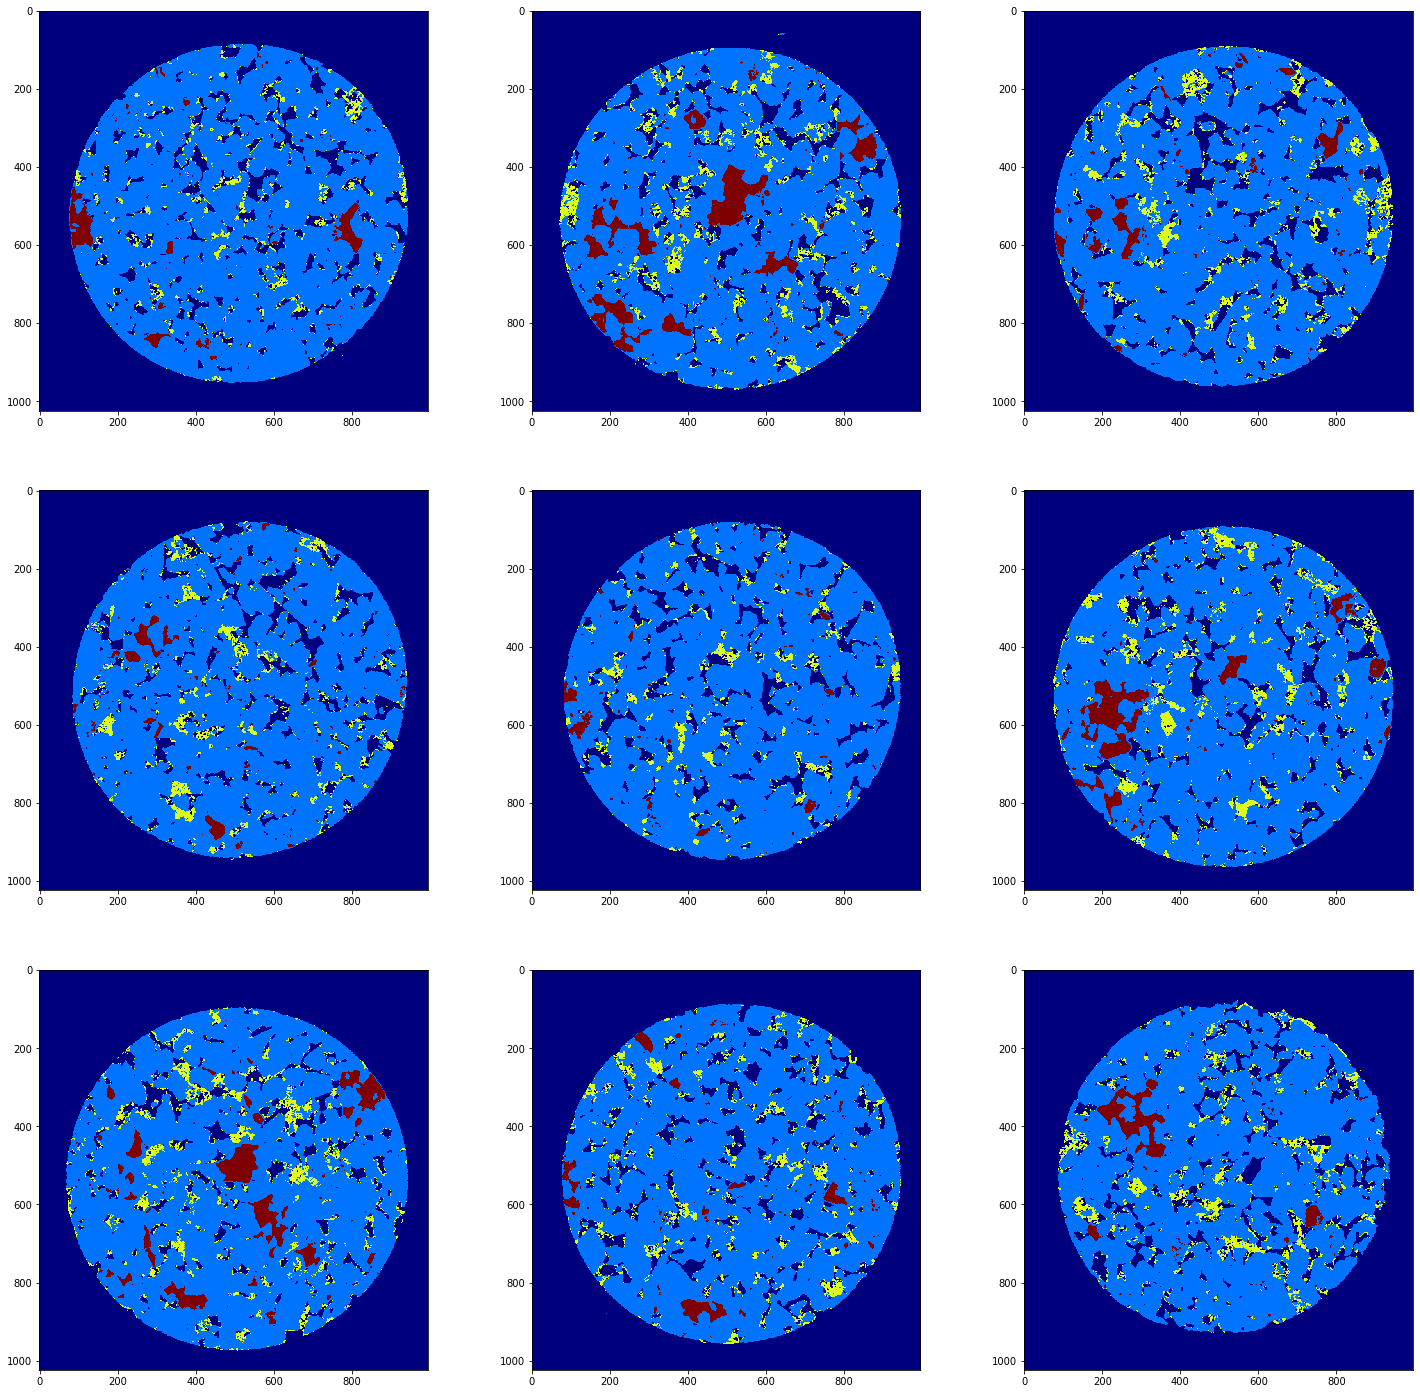

In [134]:
fig, axs = plt.subplots(3,3, figsize=(25, 25), facecolor='w', edgecolor='k')


axs = axs.ravel()
for i in range(9):
    axs[i].imshow(add[i],cmap='jet')


# Using Multiple Images to Train a Classifier.

Ok, our last classifier (which was still pretty darn good!!) used only one image. Now we are going to practice using multiple images to train. We are going to do this by concatenating feature dataframes!

Step 1: Read Training Images and Extract Features

Step 2: Read Labeled Images (MASKS) and Create another df

Step 3: Prep data for RF

Step 4: Define classifier and fit the model

Step 5: Check accuracy

Step 6: Save model for future use

Step 7: Make prediction on new images

In [139]:
#Let's start with our old feature extraction function:
def feature_extraction(img):
    #lets now start defining a dataframe to keep all of our features
    df = pd.DataFrame()
    
    #lets add our original pixel values first
    img2 = img.reshape(-1) #unwarp image
    df['Original Image']=img2

    #now let's add Gabor features!

    num = 1

    for theta in range(2):
        theta=theta/4*np.pi  
        for sigma in (3,5):
            for lamda in np.arange(0,np.pi,np.pi/4):
                for gamma in (0.05,0.5):
                    gabor_label = 'Gabor'+str(num)
                    kernel = cv2.getGaborKernel((5,5),sigma,theta,lamda,gamma,0,ktype=cv2.CV_32F)
                    fimg = cv2.filter2D(img,cv2.CV_8UC3,kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label]=filtered_img
                    num+=1



    #Now let's add a Canny edge filter!
    edges = cv2.Canny(img,100,200)
    edges1=edges.reshape(-1)
    df['Canny Edge'] = edges1

    #Now let's add some skimage filters
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1

    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    #now some Gaussian filters

    #GAUSSIAN with sigma=3
    gaussian_img = nd.gaussian_filter(img,sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3']=gaussian_img1

    #GAUSSIAN with sigma=3
    gaussian_img2 = nd.gaussian_filter(img,sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7']=gaussian_img3

    #MEDIAN with sigma=3
    median_img = nd.median_filter(img,size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1

    #VARIANCE with size=3
    variance_img = nd.generic_filter(img,np.var,size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3']=variance_img1
    
    return df


### Now below we will simply append feature dataframes derived from successive images.

In [172]:
image_dataset=pd.DataFrame()

#some nice code to make sure that you've got nice images:
for img in tqdm(os.listdir(train_dir)):

    #read in your image file name
    image = os.path.join(train_dir,img)
    #read in your image itself
    image = cv2.imread(image)
    #ensure colors are converted to gray
    if image.ndim==3 and image.shape[-1]==3:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #ensure that grays stay gray
    elif image.ndim==2:
        image = image
    else:
        raise Exception("The module only works with grayscale and RBG images!")
    print(image.shape)
    
    intermediate_df = feature_extraction(image)
    #note below that making image_dataset = ...append() 
    #is really important. If you just do the regular
    #append method as with a list, you'll end up back up
    #with a blank dataframe.
    image_dataset = image_dataset.append(intermediate_df)

  0%|          | 0/9 [00:00<?, ?it/s]

(1024, 996)


 11%|█         | 1/9 [00:21<02:55, 21.97s/it]

(1024, 996)


 22%|██▏       | 2/9 [00:44<02:34, 22.08s/it]

(1024, 996)


 33%|███▎      | 3/9 [01:07<02:15, 22.51s/it]

(1024, 996)


 44%|████▍     | 4/9 [01:32<01:55, 23.06s/it]

(1024, 996)


 56%|█████▌    | 5/9 [01:56<01:33, 23.46s/it]

(1024, 996)


 67%|██████▋   | 6/9 [02:21<01:11, 23.78s/it]

(1024, 996)


 78%|███████▊  | 7/9 [02:49<00:50, 25.26s/it]

(1024, 996)


 89%|████████▉ | 8/9 [03:15<00:25, 25.39s/it]

(1024, 996)


100%|██████████| 9/9 [03:42<00:00, 24.76s/it]


In [174]:
image_dataset.head()

,Original Image,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Gabor31,Gabor32,Canny Edge,Roberts,Sobel,Prewitt,Gaussian s3,Gaussian s7,Median s3,Variance s3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0,0,0,0


### Now let's do the exact same thing with the mask files! This time though we're not extracting features, we are just extracting the mask label and throwing in the mask name

In [175]:
### Now let's do the exact same thing for our masks!
mask_dataset = pd.DataFrame()

for img in os.listdir(train_masks):
    intermediate_df2 = pd.DataFrame()
    #read in your image file name
    image = os.path.join(train_masks,img)
    #read in your image itself
    image = cv2.imread(image)
    
    #ensure colors are converted to gray
    if image.ndim==3 and image.shape[-1]==3:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #ensure that grays stay gray
    elif image.ndim==2:
        image = image
    else:
        raise Exception("The module only works with grayscale and RBG images!")
        

    intermediate_df2['Label']=image.reshape(-1)
#     intermediate_df2['Mask_Name'] = len(image.reshape(-1))*image
    
    mask_dataset = mask_dataset.append(intermediate_df2)


### Great. Now we have both a multi-image feature dataframe/matrix and a mult-image label dataframe. Let's concatenate them side-by-side. 

In [177]:
complete_df = pd.concat([image_dataset,mask_dataset],axis=1)

### An important point about an upcoming line of code:

Let's say you have a ton of pixels, and you only want to train on the ones that are labeled. In most programs, an unlabeled point in a mask will have a value of **0**. So, in the upcoming code, you will see the following line: 

`complete_df = complete_df[complete_df.Label!=0`

This is important if you only want to train on labeled pixels and not waste time (either your model's time, or your own time if you don't feel like annotating **all** of an image!!

In [182]:
#as above: Note that in our example, Sreeni has gone through
#and labeled everything so there actually are not any
#zero values. But in most use cases, this will be an amazing
#line of code to have in your backpocket. 
complete_df = complete_df[complete_df.Label!=0]
X = complete_df.drop(labels=['Label'],axis=1)
Y = complete_df['Label'].values

## Ok, great. By this point in the tutorial you've done everything. Only run the below lines with multiple-image training if you want to wait for a 

In [183]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=20)

In [ ]:
model = RandomForestClassifier(n_estimators = 50,random_state=42)
model.fit(X_train,y_train)

In [ ]:
prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(y_test,prediction_test)